In [10]:
# include tools
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# load data info and path
DATA_DIR = Path('data')
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')
test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')

train_values.dtypes

geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_cement_mortar_brick     int64
has_superstructure_t

<AxesSubplot: title={'center': 'Number of Buildings with Each Damage Grade'}>

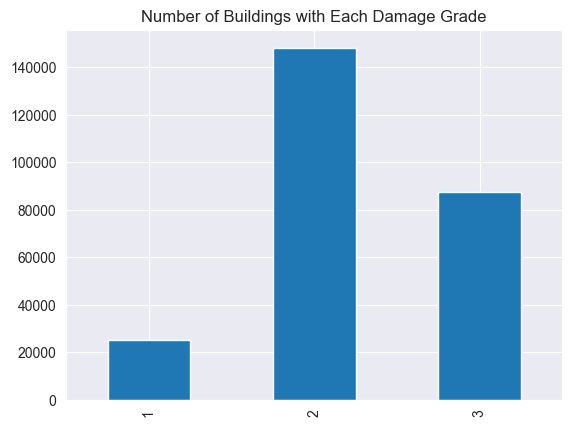

In [12]:
# explore the data
(train_labels.damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of Buildings with Each Damage Grade"))

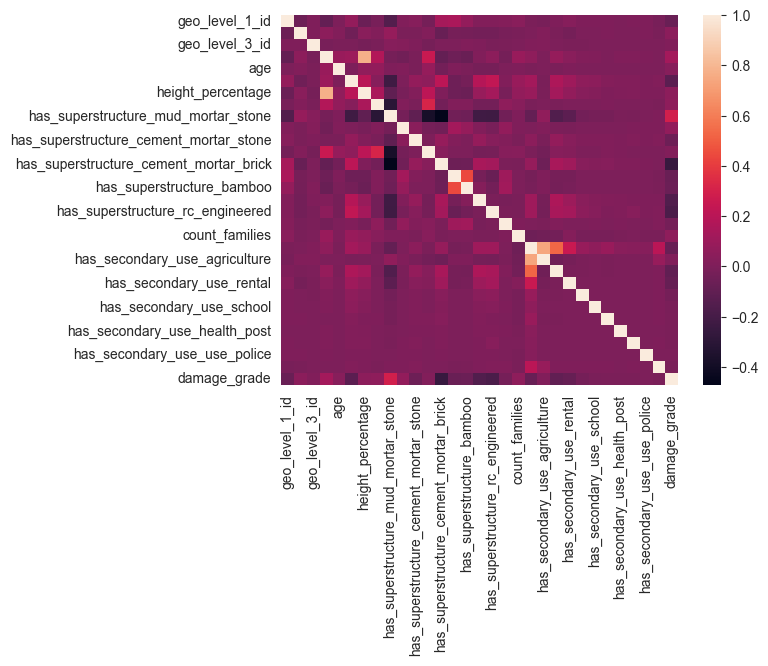

In [13]:
# a quick look at the relationships between our numeric features and labels
sns.heatmap(train_values.join(train_labels).corr(), annot=False, fmt=".2f")
plt.show()

In [14]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
import xgboost as xgb

# for combining to preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [15]:
# pipeline and selective features
xg_cols=['geo_level_1_id','geo_level_2_id','geo_level_3_id','land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status','count_floors_pre_eq', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other']

# select the subset of features we used to train the model and create dummy variables.
#train_values_subset = train_values
train_values_subset = train_values[xg_cols]
train_values_subset = pd.get_dummies(train_values_subset)

# select test values
#test_values_subset = test_values
test_values_subset = test_values[xg_cols]
test_values_subset = pd.get_dummies(test_values_subset)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 68 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   geo_level_1_id                          260601 non-null  int64
 1   geo_level_2_id                          260601 non-null  int64
 2   geo_level_3_id                          260601 non-null  int64
 3   count_floors_pre_eq                     260601 non-null  int64
 4   has_superstructure_adobe_mud            260601 non-null  int64
 5   has_superstructure_mud_mortar_stone     260601 non-null  int64
 6   has_superstructure_stone_flag           260601 non-null  int64
 7   has_superstructure_cement_mortar_stone  260601 non-null  int64
 8   has_superstructure_mud_mortar_brick     260601 non-null  int64
 9   has_superstructure_cement_mortar_brick  260601 non-null  int64
 10  has_superstructure_timber               260601 non-null  int64


In [16]:
# training pipeline
pipe = make_pipeline(StandardScaler(),
                     xgb.XGBClassifier(random_state=2018, objective="multi:softmax", num_class=3))

pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_esti

In [ ]:
# hyperparameter search
param_grid = {
    'xgbclassifier__n_estimators': [100, 200],
    'xgbclassifier__learning_rate': [0.1, 0.3],
    'xgbclassifier__max_depth': [3, 6],
    'xgbclassifier__min_child_weight': [1, 5],
    'xgbclassifier__gamma': [0, 0.1],
    'xgbclassifier__subsample': [0.8, 1],
    'xgbclassifier__colsample_bytree': [0.8, 1],
}

gs = GridSearchCV(pipe, param_grid, cv=5)

# desire output class label for sklearn is (0, 1, 2), training label is (1, 2, 3)
gs.fit(train_values_subset, train_labels.values.ravel() - 1)
gs.best_params_

In [9]:
# calculate train F1 micro score
from sklearn.metrics import f1_score

in_sample_preds = gs.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average='micro')

NotFittedError: need to call fit or load_model beforehand

In [ ]:
# make prediction
# desire output class label for sklearn is (0, 1, 2), training label is (1, 2, 3)
predictions = gs.predict(test_values_subset)
predictions += 1

# save submission
submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission.head()

In [ ]:
# save to submission
my_submission.to_csv('submission.csv')
# check the head of the saved file
!type submission.csv

In [ ]:
# get feature importances and graph, could look further into these to improve the model further
model = gs.best_estimator_.named_steps['xgbclassifier']
importances = model.get_booster().get_score(importance_type='gain')
importances = pd.Series(importances)
importances_sorted = importances.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances_sorted.plot(kind='bar')
plt.title("Feature Importances")
plt.show()